In [1]:
%matplotlib inline

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.mat_gen import normal, uniform

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, basinhopping


In [2]:
# Section to reproduce 
# (if 0: reproduces Overview fig.1 ; if 1: reproduces section3.2 fig.12)
# The differences are (1) sequences p3 and p4 change, and (2) plots for singular values are different (number of values shown, C or R matrix, log or linear)
section = 1

rpy.set_seed(80) # The results seem really dependent on the seed

In [3]:
reservoir = Reservoir(
    100, 
    lr=1, 
    sr=1.5, 
    input_scaling=1.5, 
    bias_scaling=.2, 
    rc_connectivity=.1,
    W=uniform, # not specified but improves fit over normal dist
    Win=normal,
    bias=normal,
    input_connectivity=1 # better NRMSE for W, but appears to be worse for conceptor reconstruction. Not specified in Jaeger (2014)
)
readout = Ridge(ridge=.01, input_bias=False) # no bias is mentioned
recurrence = Ridge(ridge=.0001, input_bias=False) # we don't want to use a bias since we're looking for a weight matrix


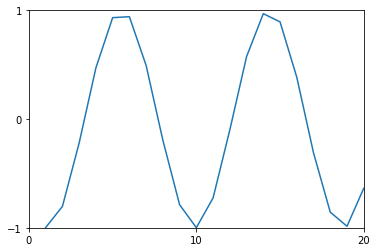

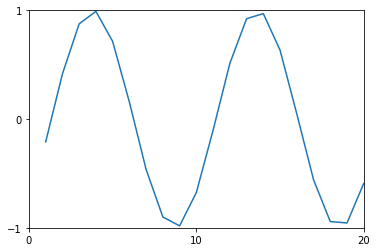

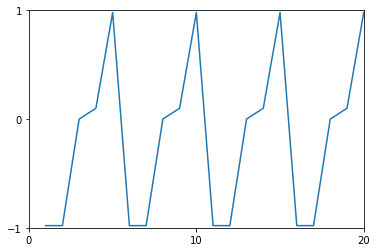

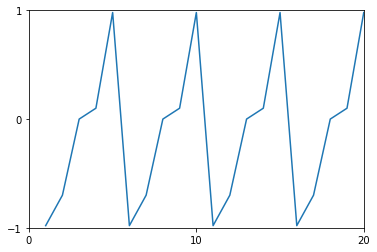

In [4]:
def plot_sequence(x, seq, n_timesteps=20, show=True, ax=plt, **kwargs):
    ax.plot(x[:n_timesteps], seq[:n_timesteps], **kwargs)
    if ax==plt:
        plt.xlim(0,n_timesteps)
        plt.xticks([0,10,n_timesteps])
        plt.ylim(-1,1)
        plt.yticks([-1,0,1])
    else:
        ax.set_xlim(0,n_timesteps)
        ax.set_xticks([0,10,n_timesteps])
        ax.set_ylim(-1,1)
        ax.set_yticks([-1,0,1])
    if show:
        plt.show()
    
    
x = np.arange(20*5000)+1
p1 = np.sin(2*np.pi*x/(8.83)).reshape(-1, 1)
p2 = np.sin(2*np.pi*x/(9.83)).reshape(-1, 1)

# Let's try to infer p3 and p4 used in Jaeger (2014) visually (just by looking at the figures)
p3 = np.array(([-.98,-.98,0,.1,.98] if section else [.98,-.98,-.05,-.5,.15])*4*5000).reshape(-1, 1)
p4 = np.array(([-.98,-.7,0,.1,.98] if section else [.98,-.98,-.6,-.5,.15])*4*5000).reshape(-1, 1)

sequences = [p1, p2, p3, p4]
for seq in sequences:
    plot_sequence(x, seq[500:])






# Train the readout

We train a readout to recognize all four sequences

In [5]:

X = np.array([reservoir.run(sequence[:1500], reset=True) for sequence in sequences])
Y = np.array([sequence[:1500] for sequence in sequences])
readout = readout.fit(X, Y, warmup=500)


Running Reservoir-0: 100%|██████████| 1500/1500 [00:00<00:00, 18589.63it/s]


Running Ridge-0: 100%|██████████| 2000/2000 [00:00<00:00, 40517.43it/s]


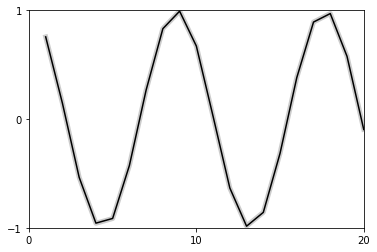

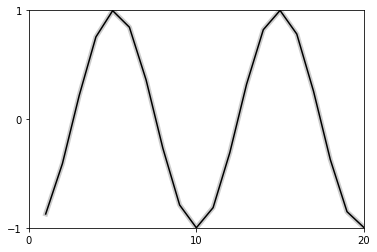

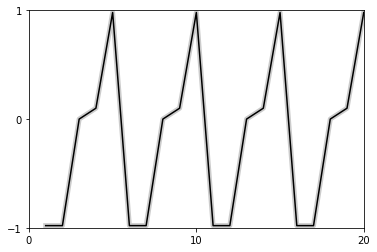

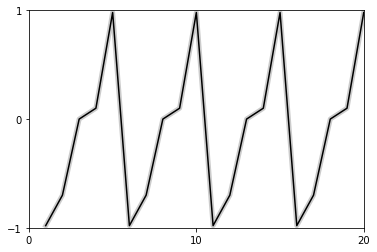

In [6]:
test_states = [reservoir.run(sequence[:2000], reset=True) for sequence in sequences]
Y_pred = [readout.run(test_states[i]) for i in range(len(sequences))]
for i in range(len(sequences)):
    plot_sequence(x, sequences[i][1000:], show=False, color='black')
    plot_sequence(x, Y_pred[i][1000:], show=False, linewidth=5, alpha=.2, color='black')
    plt.show()


# Train the recurrence

We train a "readout" to find a new weight matrix for the reservoir that is able to reproduce the dynamics of the reservoir driven by the four sequences without the sequences being fed as input to the reservoir.

In [7]:
states = np.array([reservoir.run(sequence[:1501], reset=True) for sequence in sequences])
X = np.array([states[i][1:] for i in range(len(sequences))])
X_tilde = np.array([states[i][:-1] for i in range(len(sequences))]) # delayed states
b = reservoir.bias if type(reservoir.bias)==np.ndarray else reservoir.bias.toarray()
recurrence = recurrence.fit(X_tilde, np.arctanh(X)-b[:,0], warmup=499)

pred = np.array([recurrence.run(X_tilde[i][500:]) for i in range(len(sequences))])
truth = np.arctanh(X[:,500:,:])-b[:,0]

NRMSE = np.sqrt(((pred - truth)**2).mean()/(truth**2).mean())

print("The NRMSE is:",NRMSE, "(is 0.0011 in Jaeger (2014, p.162))")

Running Ridge-1: 100%|██████████| 1000/1000 [00:00<00:00, 17318.02it/s]


The NRMSE is: 0.0025081967985369487 (is 0.0011 in Jaeger (2014, p.162))


We then create a copy of the reservoir with the new weight matrix

In [8]:
loaded_reservoir = reservoir.copy()
loaded_reservoir.set_param('W', recurrence.get_param('Wout'))

Running Ridge-0: 100%|██████████| 500/500 [00:00<00:00, 23053.73it/s]


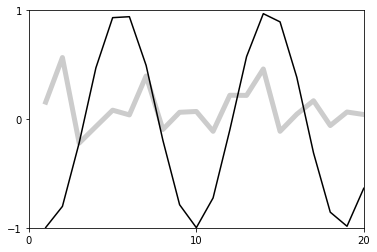

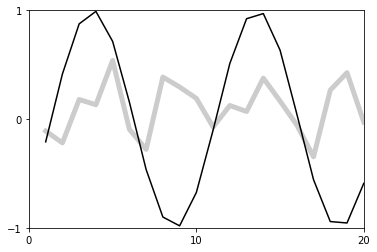

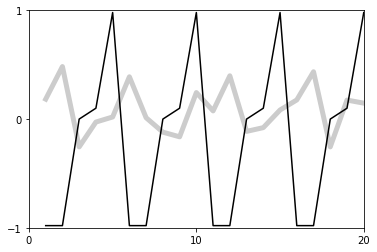

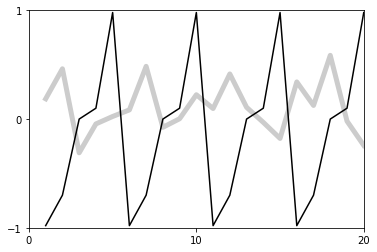

In [9]:
test_states = np.array([loaded_reservoir.run(np.zeros((500,1)), from_state=X[i][500,:]) for i in range(len(sequences))])
Y_pred = np.array([readout.run(test_states[i]) for i in range(len(sequences))])

for i in range(len(sequences)):
    plot_sequence(x, sequences[i][500:], show=False, color='black')
    plot_sequence(x, Y_pred[i][:], show=False, linewidth=5, alpha=.2, color='black')
    plt.show()


# Create a conceptor

In [10]:
# A = np.random.random((50,50))
# U,S,V_H = np.linalg.svd(A)
# print(S)
# print(U.shape, S.shape, V_H.shape)
# print((U*S).shape)
# print(A-np.dot(U*S,V_H))

def create_conceptor(states, warmup, aperture, return_R=False, thr_low=0, thr_hi=1):
    X = states[warmup:]
    R = np.dot(X.T,X)/X.shape[0] # correlation matrix
    C = np.matmul(R, np.linalg.pinv(R+np.identity(X.shape[1])/aperture**2))
    
    # zero small singular values and set large ones to one
    U,S,V = np.linalg.svd(C)
    S[np.where(S>thr_hi)] = 1
    S[np.where(S<thr_low)] = 0  
    C = np.dot(U*S, V)
    
    if return_R:
        return C,R
    return C

# def zeroing(C):
#     lkjzer
    
def plot_sv(mat, log, title="", ax=plt, show=True, n_values=None):
    if n_values is None:
        n_values = mat.shape[0]
    _,S,_ = np.linalg.svd(mat)
    if log:
        S = np.log10(S)
    
    ax.plot(S[:n_values], color='k')
    if ax==plt:
        plt.title(title)
    else:
        ax.set_title(title)
    if show:
        plt.show()


Now let's try to reproduce the sequences by filtering through the conceptors. 

**Note that it's okay if the reproduced pattern is offset**. Most importantly, the amplitude and "shape" of the sequences should be reproduced.

Running Ridge-0: 100%|██████████| 500/500 [00:00<00:00, 28101.03it/s]


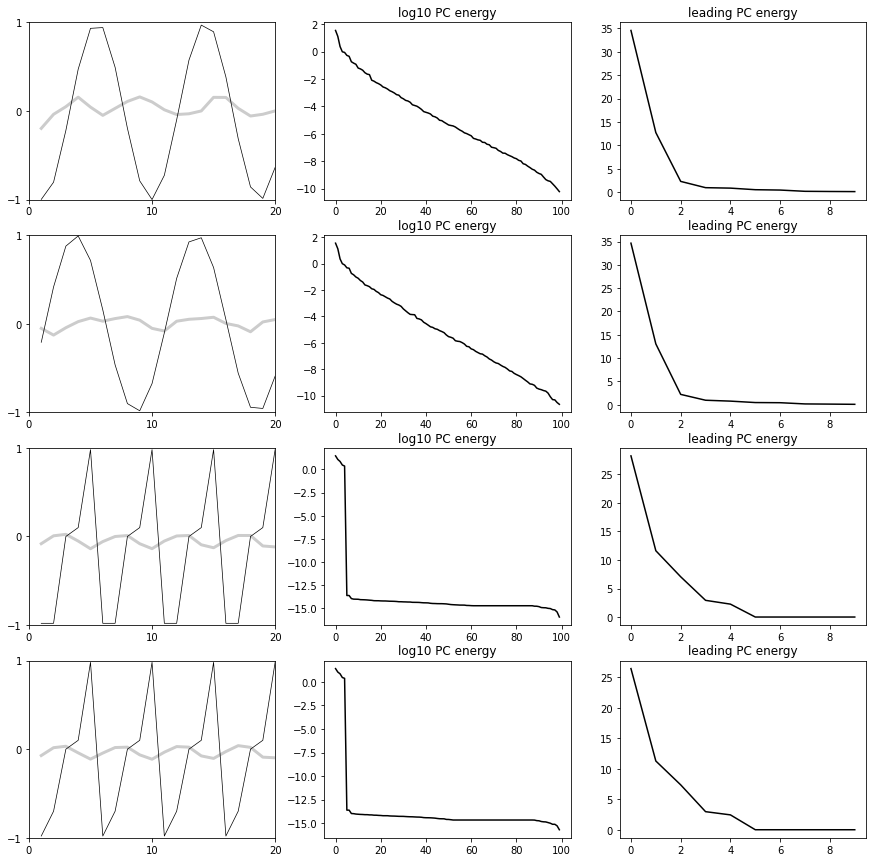

In [11]:
test_states = np.zeros(test_states.shape)
Y_pred = np.zeros(Y_pred.shape)

W = loaded_reservoir.W
b = reservoir.bias

def conceptor_run(C, X_0, W, b, n_timesteps=500):
    Z = np.zeros((n_timesteps+1, X_0.size))
    X = np.zeros((n_timesteps+1, X_0.size))
    
    X[0,:] = X_0
    for i in range(n_timesteps):
        Z[i+1,:] = np.array(np.tanh(np.dot(W,X[i,:,None])+b))[:,0]
        X[i+1,:] = np.dot(C, Z[i+1,:]) # filter by conceptor
        X[i+1,:] = np.dot(C, Z[i+1,:]) # filter by conceptor
        
    return X[1:],Z[1:] # remove initialization step

fig, axes = plt.subplots(nrows=len(sequences), ncols=3, figsize=(15,15))
for i in range(len(sequences)):
    
    C,R = create_conceptor(X[i,:,:], warmup=500, aperture=10**2.1, return_R=True)
    
    # compute filtered dynamics
    test_states,_ = conceptor_run(C, X[i,500], W, b, 500)
        
    # decode dynamics with readout
    Y_pred = readout.run(test_states)
    
    # plot singular values and signals
    plot_sv(R, log=True, title="log10 PC energy", ax=axes[i,1], show=False)
    if section:
        plot_sv(R, log=False, title="leading PC energy", ax=axes[i,2], show=False, n_values=10)
    else:
        plot_sv(C, log=False, title="s", ax=axes[i,2], show=False)
    plot_sequence(x, sequences[i][500:], show=False, ax=axes[i,0], color='black', linewidth=0.7)
    plot_sequence(x, Y_pred, show=False, ax=axes[i,0], linewidth=3, alpha=.2, color='black')


    
plt.show()


Now let's try to find a good aperture value for each sequence, using the attenuation minimization criterion.

Starting processing sequence 1
                        fun: 2.160881781184584e-09
 lowest_optimization_result:       fun: 2.160881781184584e-09
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([7.])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 3
                       nfev: 736
                        nit: 20
                       njev: 368
                          x: array([7.])


Running Ridge-0: 100%|██████████| 500/500 [00:00<00:00, 13460.88it/s]

Starting processing sequence 2


                        fun: 5.541363829009018e-09
 lowest_optimization_result:       fun: 5.541363829009018e-09
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 22
      nit: 2
     njev: 11
   status: 0
  success: True
        x: array([7.])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 1
                       nfev: 526
                        nit: 20
                       njev: 263
                          x: array([7.])


Running Ridge-0: 100%|██████████| 500/500 [00:00<00:00, 21744.76it/s]

Starting processing sequence 3


                        fun: 0.9730601436276451
 lowest_optimization_result:       fun: 0.9730601436276451
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.33066907e-08])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 40
      nit: 7
     njev: 20
   status: 0
  success: True
        x: array([-0.05559802])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 516
                        nit: 20
                       njev: 258
                          x: array([-0.05559802])


Running Ridge-0: 100%|██████████| 500/500 [00:00<00:00, 21941.33it/s]

Starting processing sequence 4


                        fun: 0.9579307310849362
 lowest_optimization_result:       fun: 0.9579307310849362
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 4
     njev: 12
   status: 0
  success: True
        x: array([6.60131403])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 2
                       nfev: 482
                        nit: 20
                       njev: 241
                          x: array([6.60131403])


Running Ridge-0: 100%|██████████| 500/500 [00:00<00:00, 20242.78it/s]


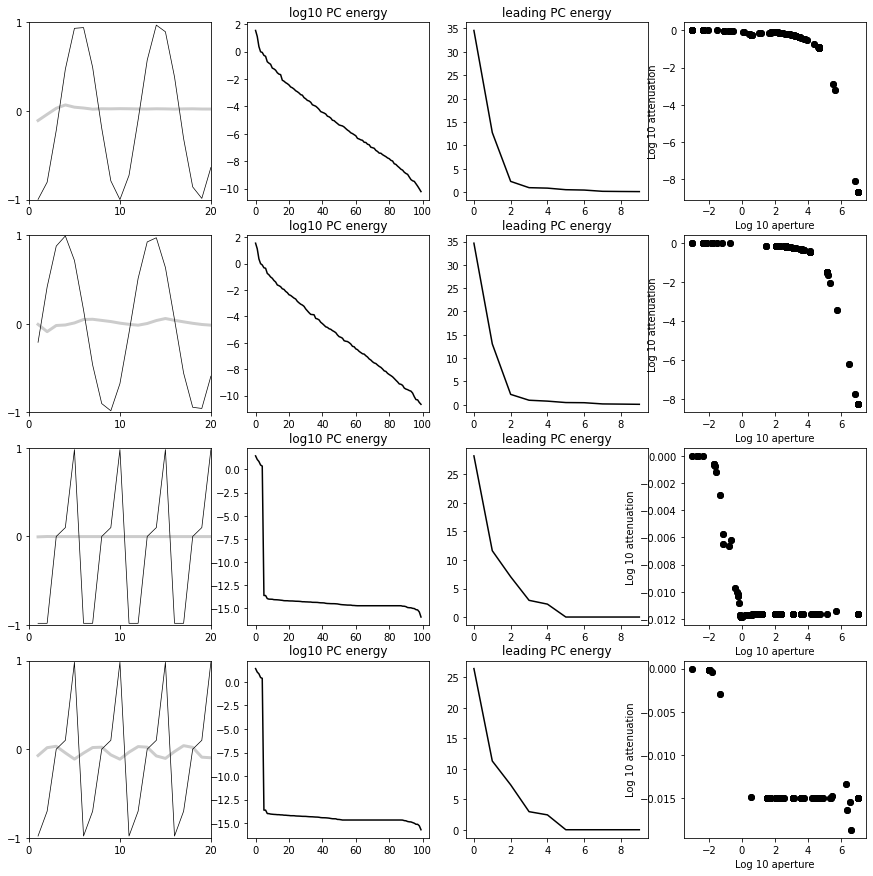

In [12]:
test_states = np.zeros(test_states.shape)
Y_pred = np.zeros(Y_pred.shape)

W = loaded_reservoir.W
b = reservoir.bias

aperture_evaluations_log10_aperture = {k:[] for k in range(len(sequences))}
aperture_evaluations_attenuation = {k:[] for k in range(len(sequences))}

def attenuation(log10_aperture, sequence, X_0, W, b, i):
    C,R = create_conceptor(sequence, warmup=500, aperture=10**log10_aperture, return_R=True)
    X,Z = conceptor_run(C, X_0, W, b, 500)
    resulting_attenuation = np.mean(np.linalg.norm((Z-X), axis=1)**2)/np.mean(np.linalg.norm(Z, axis=1)**2)
    
#     print("log10_aperture:", log10_aperture, "->", np.log10(resulting_attenuation))
    aperture_evaluations_log10_aperture[i].append(log10_aperture)
    aperture_evaluations_attenuation[i].append(resulting_attenuation)
    
    return resulting_attenuation


fig, axes = plt.subplots(nrows=len(sequences), ncols=4, figsize=(15,15))
for i in range(len(sequences)):
    
    print("Starting processing sequence", i+1)
    
    # create conceptor
    minimizer_kwargs = {
        "method": "L-BFGS-B",
        "args": (X[i], X[i,500], W, b, i),
        "bounds": ((-3,7),)
#         "bounds": ((-2,4),)
    }
    results = basinhopping(
        attenuation, 
        2.1, 
        niter=20,
        minimizer_kwargs=minimizer_kwargs,
        stepsize=5
    )
    print(results)
    C,R = create_conceptor(X[i,:,:], warmup=500, aperture=results["x"], return_R=True)
    
    # compute filtered dynamics
    test_states,_ = conceptor_run(C, X[i,500], W, b, 500)
        
    # decode dynamics with readout
    Y_pred = readout.run(test_states)
    
    # plot singular values and signals
    plot_sv(R, log=True, title="log10 PC energy", ax=axes[i,1], show=False)
    if section:
        plot_sv(R, log=False, title="leading PC energy", ax=axes[i,2], show=False, n_values=10)
    else:
        plot_sv(C, log=False, title="s", ax=axes[i,2], show=False)
    plot_sequence(x, sequences[i][500:], show=False, ax=axes[i,0], color='black', linewidth=0.7)
    plot_sequence(x, Y_pred, show=False, ax=axes[i,0], linewidth=3, alpha=.2, color='black')

    axes[i,3].scatter(aperture_evaluations_log10_aperture[i], np.log10(aperture_evaluations_attenuation[i]), color='black')
    axes[i,3].set_xlabel("Log 10 aperture")
    axes[i,3].set_ylabel("Log 10 attenuation")
    axes[i,3].plot(color='black')
#     axes[i,3].set_ylim(-10,0)



plt.show()

From Jaeger (2014):
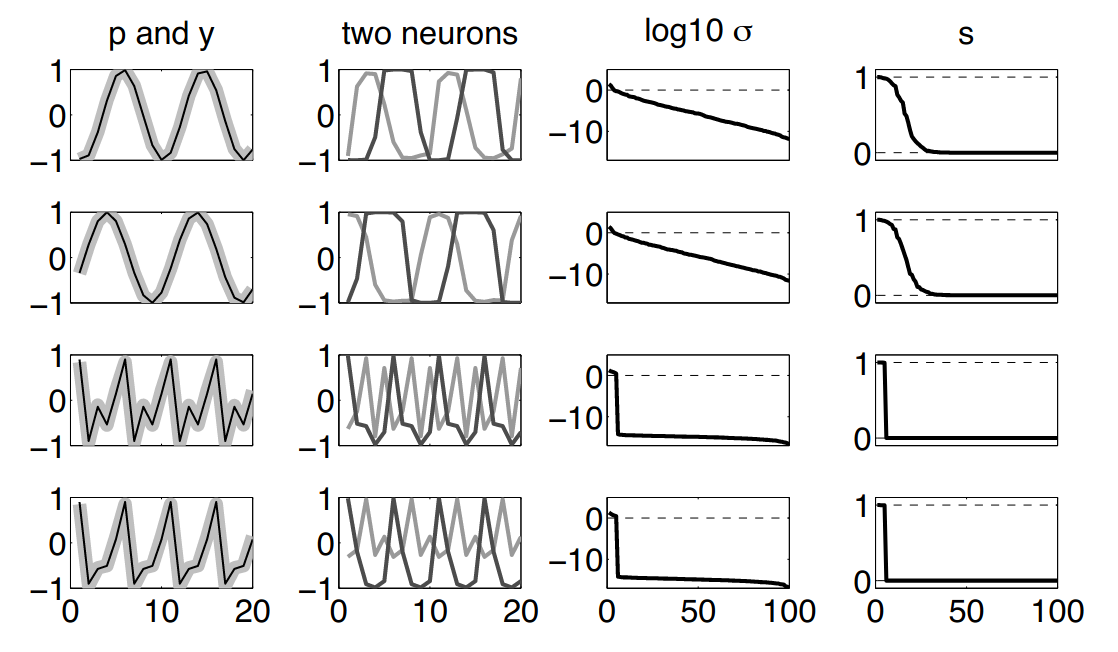
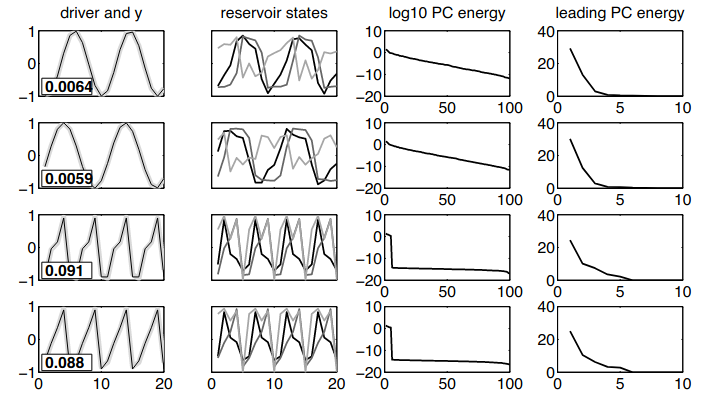